# **Trabajo Práctico N° 1 Aprendizaje Automático II 2025**

### **Redes Densas y Convolucionales**

---
**Alumnos:**


*   **Casado Pedro**

*   **Leguiza Claudia E.**

---



### **PROBLEMA 1**

## **Librerias**

In [ ]:
!pip install keras

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
sns.set()

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

In [ ]:
print(tf.__version__)


2.18.0


# **Problema 1**

## **Carga del dataset**

Dataset:
https://drive.google.com/file/d/1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc/view?usp=drive_link


**El dataset contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él.**

In [ ]:
#Descargamos el dataset
!gdown 1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc

Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100% 49.7k/49.7k [00:00<00:00, 86.2MB/s]


In [ ]:
import zipfile
import os
zip_path = '/content/TP1-1-student_performance.zip'

# Descomprimimos el archivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
data = pd.read_csv("Student_Performance.csv")

## **Objetivo:**
Utilizando el dataset proporcionado, el objetivo es construir un modelo de regresión utilizando redes neuronales que pueda predecir con precisión el índice de rendimiento académico de los estudiantes.


## **Analisis exploratorio**

In [ ]:
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


**El dataset contiene 8 características relevantes con información:**

*  **Hours Studied**: El número total de horas dedicadas al estudio por cada estudiante.

* **Previous Scores**: Las puntuaciones obtenidas por los estudiantes en exámenes previos.

* **Extracurricular Activities**: Si el estudiante participa en actividades extracurriculares (Sí o No).

* **Sleep Hours**: El número promedio de horas de sueño que el estudiante tuvo por día.

* **Sample Question Papers Practiced**: El número de cuestionarios de muestra que el estudiante practicó.

* **Performance Index**: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.

In [ ]:
data.columns = data.columns.str.replace(' ', '_')

In [ ]:
#Renombramos la variable mejor visualización en gráficos
data.rename(columns={'Sample_Question_Papers_Practiced': 'Quiz'}, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Hours_Studied               10000 non-null  int64  
 1   Previous_Scores             10000 non-null  int64  
 2   Extracurricular_Activities  10000 non-null  object 
 3   Sleep_Hours                 10000 non-null  int64  
 4   Quiz                        10000 non-null  int64  
 5   Performance_Index           10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


**El set de datos contiene  5 variables numéricas y una categorica. Contiene un total de 10000 registros.**

*   **Las variables numéricas tienen tipo de datos int64 y float64.**

*   **Además, no hay presencia de valores faltantes en el conjunto de datos.**

In [ ]:
#Vamos a pasar las columnas de tipo int64 a float para tener consistencia de unidades en el dataset.
int_columns = ['Hours_Studied', 'Previous_Scores', 'Sleep_Hours', 'Quiz']
data[int_columns] = data[int_columns].astype(float)

####Separación conjunto entrenamiento y test

In [ ]:
#Vamos a separar entre la matriz de features y la target
X = data.drop('Performance_Index', axis=1)
y = data['Performance_Index'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertimos y_train a un DataFrame para poder combinarlo con X_train temporalmente para realizar visualizaciones gráficas
# También queremos a y_test como Dataframe
y_train_df = pd.DataFrame(y_train, columns=['Performance_Index'])
y_test_df = pd.DataFrame(y_test, columns=['Performance_Index'])

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 5), (2000, 5), (8000, 1), (2000, 1))

In [ ]:
#Hacemos un reset del indice de X_train para que se correlacione con el indice de y_train_df
X_train.reset_index(drop=True, inplace=True)

In [ ]:
# Concatenamos X_train con y_train_df para poder visualizar
data_train = pd.concat([X_train, y_train_df], axis=1)

In [ ]:
data_train.describe()

,Hours_Studied,Previous_Scores,Sleep_Hours,Quiz,Performance_Index
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4.983250,69.531000,6.541625,4.616500,55.311500
std,2.594862,17.343735,1.698493,2.861241,19.202059
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.750000,5.000000,2.000000,40.000000
50%,5.000000,70.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


### **Visualizaciones**

####Boxplots

Primero vamos a analizar si hay alguna diferencia aparente en la distribución de los datos dependiendo si se realizaron actividades extracurriculares. Para eso realizaremos gráficos de boxplot para cada variable.

In [ ]:
columnas_float = data_train.select_dtypes(include=['float']).columns

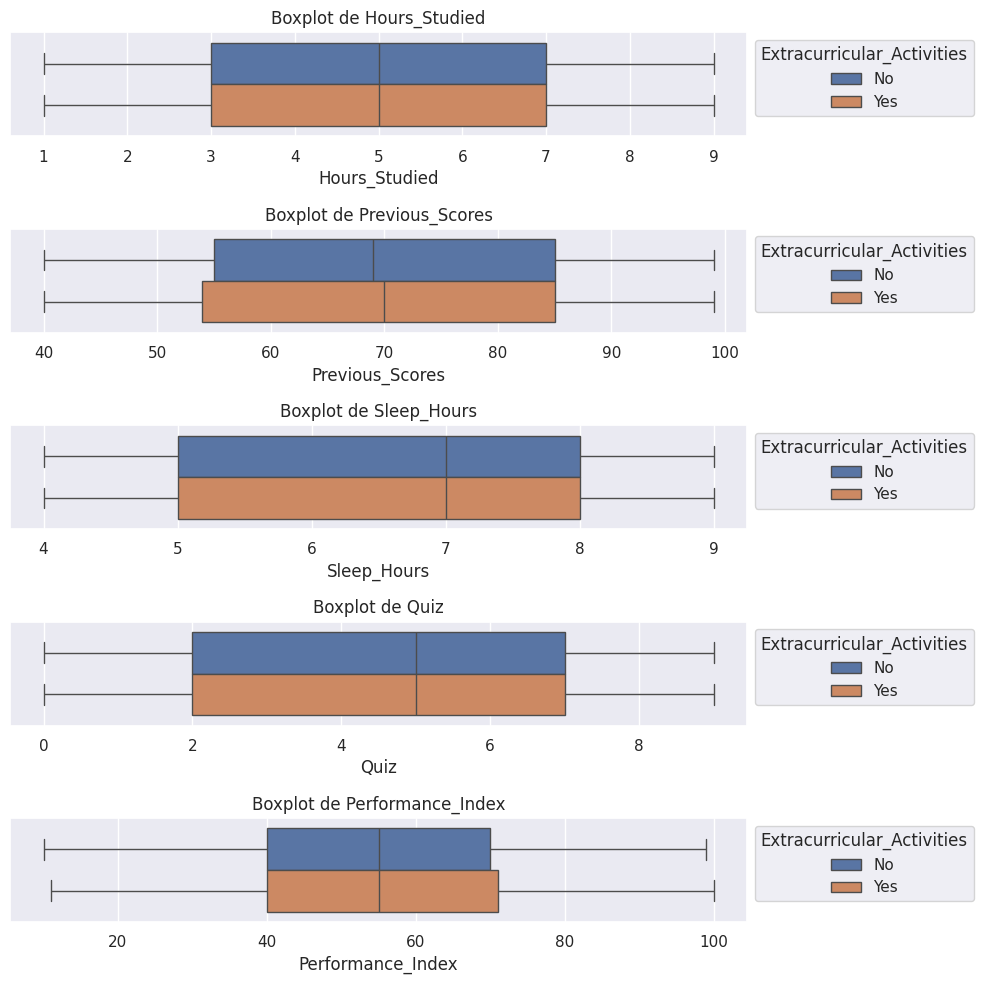

In [ ]:
#Subplots individuales para cada columna
fig, axes = plt.subplots(nrows=len(columnas_float), ncols=1, figsize=(10, 2 * len(columnas_float)))

# Generar un boxplot por cada columna
for i, col in enumerate(columnas_float):
    sns.boxplot(data=data_train, x=col, ax=axes[i], hue='Extracurricular_Activities')
    sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1))
    axes[i].set_title(f'Boxplot de {col}')

plt.subplots_adjust(hspace=0.45)
plt.tight_layout()

En los graficos de cajas observamos lo siguiente:

*   No hay valores atipicos en los atributos
*   La variable categorica no incide en el comportamiento del resto de las varables.


*   Presentan una distribucion normal las variables Hours_Studied, Previous_Scores y Performance_Index
*   Las variables Sleep_Hours y Quiz estan sesgadas a la derecha.





#### **Matriz de correlacion**

Ahora vamos a investigar si encontramos algunas correlaciones entre las variables númericas.

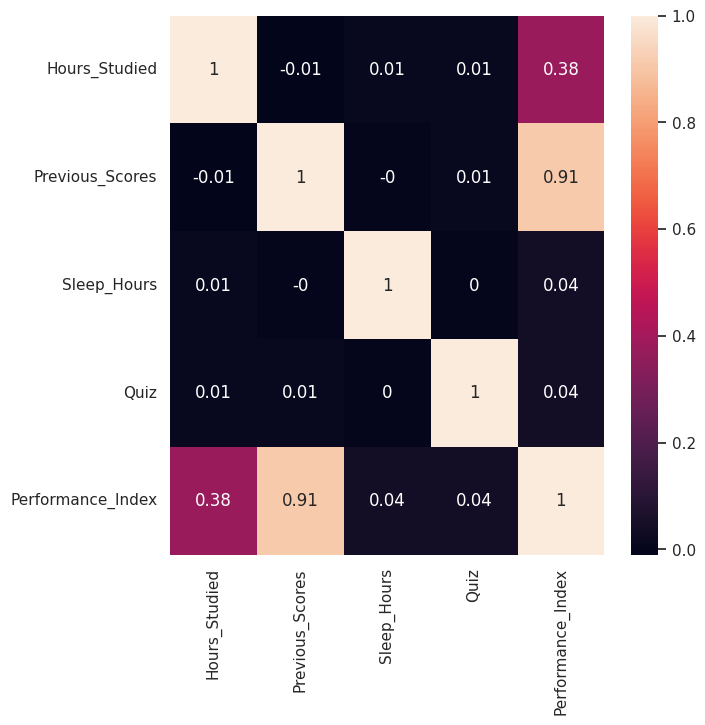

In [ ]:
corr = data_train.drop('Extracurricular_Activities', axis=1)\
           .corr().round(2)

plt.figure(figsize = (7,7))
sns.heatmap(corr, annot=True)
plt.show()

El mapa de correlaciones nos revela una muy fuerte correlación lineal positiva entre **Previous_Scores** y **Performance_Index**. Esto tiene sentido ya que significaría que el rendimiento de los estudiantes esta muy vinculado a las notas que se sacaron en los exámenes previos

También tenemos una moderada relación entre la cantidad de horas dedicadas al estudio y su rendimiento academico.

####Regplot

Para visualizar mejor las relaciones marcadas que encontramos en el heatmap anterior vamos a realizar un Regplot de las variables Previous_Scores, Hours_Studied y Performance_Index

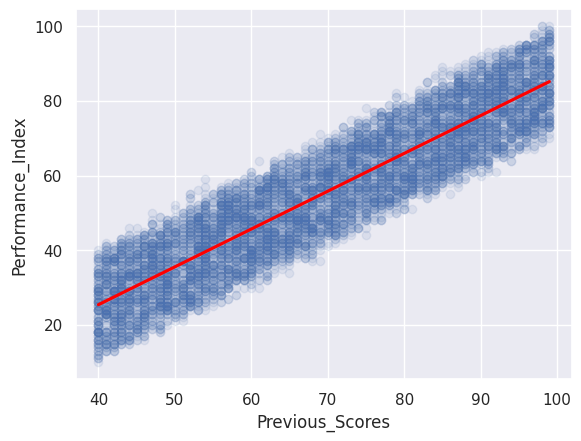

In [ ]:
sns.regplot(x='Previous_Scores', y='Performance_Index',\
            data=data_train, scatter_kws={'alpha':0.1}, line_kws={'color': 'red'})
plt.show()

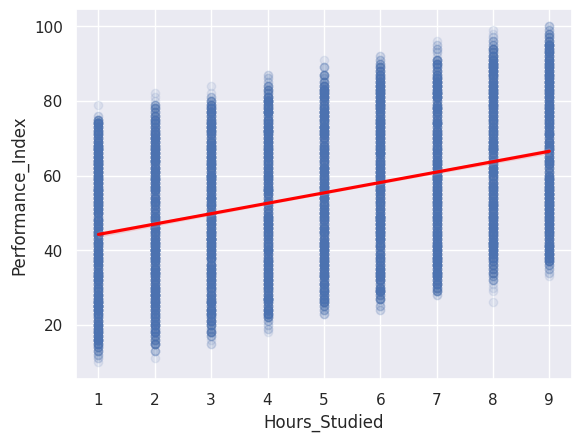

In [ ]:
sns.regplot(x='Hours_Studied', y='Performance_Index', \
            data=data_train, scatter_kws={'alpha':0.1}, line_kws={'color': 'red'})
plt.show()

En estos gráficos podemos realmente visualizar la relación lineal que tienen estas variables. En el caso de Performance_Index y Previous_Scores la relación lineal es casi 1 a 1, mientras que con Hours_Studied es un poco menos marcada.

####**Conclusiones analisis exploratorio**

Después de analizar los datos, observamos que las variables que presentan mayor relevancia para predecir el Performance_Index son Previous_Scores y, en menor medida, Hours_Studied. Aunque es posible que las demás variables influyan de manera no lineal, los análisis realizados sugieren que su aporte sería limitado, y que el modelo se apoyará principalmente en estas dos características.

Este comportamiento puede indicar que utilizar un modelo complejo como una **red neuronal** no sea necesario para abordar este problema, ya que un modelo más simple, como una **regresión lineal**, podría ser suficiente para alcanzar un rendimiento comparable.

Teniendo esto en cuenta, además del modelo de redes neuronales, también probaremos un modelo de regresión lineal para comparar los resultados obtenidos y evaluar si la complejidad adicional se justifica.



##**Definición y entrenamiento de modelos**

###Preprocesado de los datos

Para poder usar nuestros datos para entrenar primero debemos codificar la variable categorica "Extracurricular_Activities" y escalar los datos para que la diferencia de escala no influencie los modelos.

In [ ]:
X_train_scaled = X_train.copy()
X_train_scaled["Extracurricular_Activities"] = X_train_scaled["Extracurricular_Activities"].map({"No": 0, "Yes": 1})

X_test_scaled = X_test.copy()
X_test_scaled["Extracurricular_Activities"] = X_test_scaled["Extracurricular_Activities"].map({"No": 0, "Yes": 1})

In [ ]:
#Codificamos la variable Extracurricular_Activities
X_train_scaled = X_train.replace({"No": 0, "Yes": 1})
X_test_scaled = X_test.replace({"No": 0, "Yes": 1})

<ipython-input-33-fc4705781747>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_scaled = X_train.replace({"No": 0, "Yes": 1})
<ipython-input-33-fc4705781747>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_scaled = X_test.replace({"No": 0, "Yes": 1})


In [ ]:
#Hacemos un reset del indice de X_test para evitar problemas con el escalado
X_test_scaled.reset_index(drop=True, inplace=True)

In [ ]:
#Normalizamos los datos
scaler = StandardScaler()
X_train_scaled[['Hours_Studied',	'Previous_Scores', 'Sleep_Hours','Quiz']] = pd.DataFrame(scaler.fit_transform(X_train_scaled[['Hours_Studied',	'Previous_Scores', 'Sleep_Hours','Quiz']]))
X_test_scaled[['Hours_Studied',	'Previous_Scores', 'Sleep_Hours','Quiz']] = pd.DataFrame(scaler.transform(X_test_scaled[['Hours_Studied',	'Previous_Scores', 'Sleep_Hours','Quiz']]))

###Regresión Lineal

In [ ]:
LinearRModel = LinearRegression()
LinearRModel.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# Medimos ajuste en el conjunto de testeo
y_predict_linear = LinearRModel.predict(X_test_scaled)

# Calculamos RMSE "a mano"
rmse_linear_test = np.sqrt(mean_squared_error(y_test, y_predict_linear))
r2_linear_test = r2_score(y_test, y_predict_linear)

print(f"Test Results - Linear Regression")
print(f"RMSE: {rmse_linear_test:.2f}")
print(f"R² Score: {r2_linear_test:.2f}")

Test Results - Linear Regression
RMSE: 2.02
R² Score: 0.99


###Regresión con Red Neuronal

In [ ]:
# Creamos el modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida para regresión
])

# Compilamos el modelo
model.compile(optimizer="adam",
              loss='mse')

#Usamos early stopping para frenar el entrenamiento
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")

# Entrenamos el modelo
history = model.fit(X_train_scaled, y_train,
                    epochs=200,
                    validation_split=0.2,
                    callbacks=[ early_stopping],
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2869.7451 - val_loss: 170.1990
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117.9612 - val_loss: 63.9573
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55.0197 - val_loss: 36.6004
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.6953 - val_loss: 26.5760
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.0678 - val_loss: 19.3771
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 18.1880 - val_loss: 13.8362
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.2781 - val_loss: 10.1356
Epoch 8/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5003 - val_loss: 7.7095
Epoch 9/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5067 - val_loss: 6.3959
Epoch 10/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5158 - val_loss: 5.4838
Epoch 11/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4186 - val_loss: 4.9875
Epoch 12/200
200/200 ━━

In [ ]:
# Predicciones
y_predict_nn = model.predict(X_test_scaled).flatten()

# Evaluación
rmse_nn_test = np.sqrt(mean_squared_error(y_test, y_predict_nn))
r2_nn_test = r2_score(y_test, y_predict_nn)

print(f"Test Results - Neural Network Regressor")
print(f"RMSE: {rmse_nn_test:.2f}")
print(f"R² Score: {r2_nn_test:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Results - Neural Network Regressor
RMSE: 2.12
R² Score: 0.99


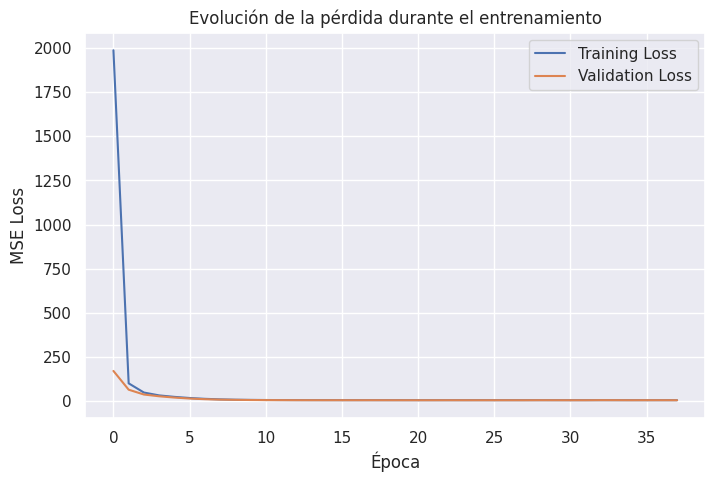

In [ ]:
# Graficar pérdida de entrenamiento y validación
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

### Conclusiones

In [ ]:
#Creamos un dataframe para visualizar los resultados de nuestros modelos
results = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Red Neuronal'],
    'RMSE': [rmse_linear_test, rmse_nn_test],
    'R²': [r2_linear_test, r2_nn_test]
})

print(results)

             Modelo      RMSE        R²
0  Regresión Lineal  2.020552  0.988983
1      Red Neuronal  2.117398  0.987902


Ambos modelos, tanto la regresión lineal como la red neuronal, tuvieron un rendimiento muy similar en términos de RMSE y R². La red neuronal no logró mejorar respecto al modelo lineal, lo que indica que la relación entre las variables probablemente sea mayormente lineal y se puede resolver bien con un modelo más simple.

En general, los dos modelos tuvieron un RMSE cercano a 2 y un R² mayor a 0.98, lo que muestra que el desempeño fue muy bueno. Cualquiera de los dos es válido para predecir el Performance_Index, aunque la regresión lineal puede ser la mejor opción por ser más simple y fácil de interpretar.